# FID - Apodization

Apodization, or time-domain filtering, is a processing step applied prior to the Fourier transformation to enhance the Signal-to-Noise Ratio (SNR) and/or the spectral resolution of MR spectra.

During apodization, the time-domain Free Induction Decay (FID) signal, $f(t)$, is multiplied by a filter function, $f_{filter}(t)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris

## 1. Generating Synthetic Data
Let's generate a synthetic FID consisting of a single decaying resonance with added Gaussian noise, packed into an `xarray.DataArray` to preserve physical coordinates.

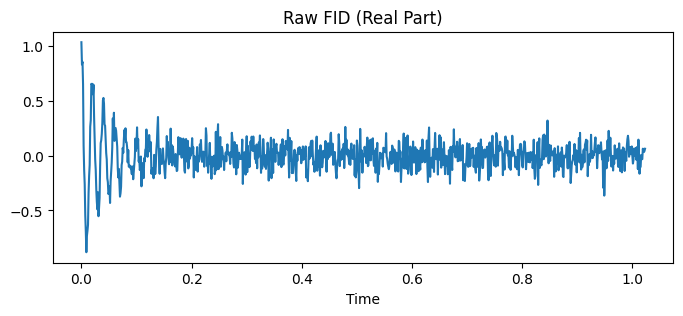

In [2]:
# Acquisition parameters
dwell_time = 0.001  # 1 ms
n_points = 1024
t = np.arange(n_points) * dwell_time

# Synthetic FID: 50 Hz resonance, T2* = 0.05s, plus complex noise
rng = np.random.default_rng(42)
clean_fid = np.exp(-t / 0.05) * np.exp(1j * 2 * np.pi * 50 * t)
noise = rng.normal(scale=0.1, size=n_points) + 1j * rng.normal(scale=0.1, size=n_points)
raw_fid = clean_fid + noise

# Xarray construction
da_fid = xr.DataArray(
    raw_fid, dims=["Time"], coords={"Time": t}, attrs={"sequence": "PRESS", "B0": 3.0}
)

da_fid.real.plot(figsize=(8, 3))
plt.title("Raw FID (Real Part)")
plt.show()

Resulting in the following, noisy spectrum.

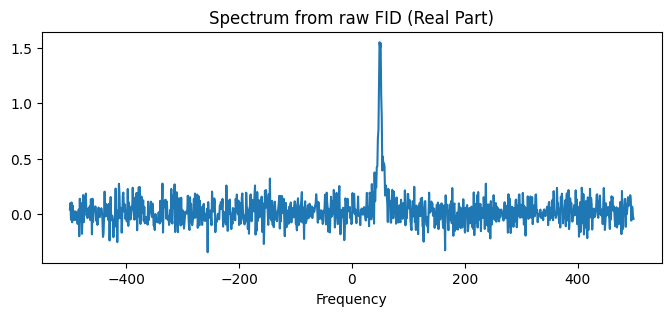

In [3]:
da_fid.xmr.to_spectrum().real.plot(figsize=(8,3))
plt.title("Spectrum from raw FID (Real Part)")
plt.show()

## 2. Exponential Apodization (Line Broadening)

A common filter function is the decreasing mono-exponential weighting: $f_{filter}(t) = e^{-t/T_L}$.

This filter improves the SNR of the spectrum because data points at the end of the FID, which primarily contain noise, are attenuated. However, this comes at the cost of causing the FID to decay faster than the natural $T_2^*$, leading to broader resonance lines. Because of this effect, time-domain apodization with a decreasing exponential is often called "line broadening".

In `xmris`, we parameterize this using the line broadening factor in Hz (`lb`), where $T_L = \frac{1}{\pi \cdot \text{lb}}$.

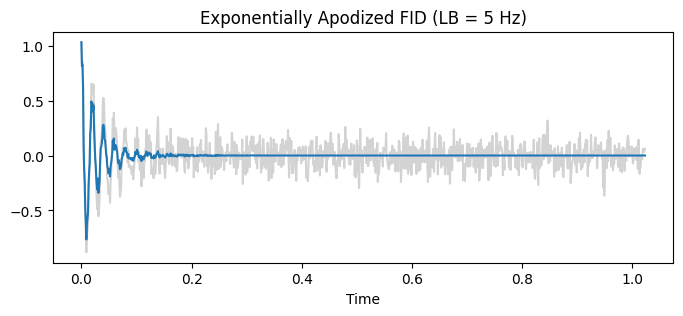

In [4]:
# Apply 5 Hz of line broadening
da_exp = da_fid.xmr.apodize_exp(dim="Time", lb=5.0)

da_fid.real.plot(figsize=(8, 3), color='lightgray')
da_exp.real.plot()

plt.title("Exponentially Apodized FID (LB = 5 Hz)")
plt.show()

Resulting in the following spectrum:

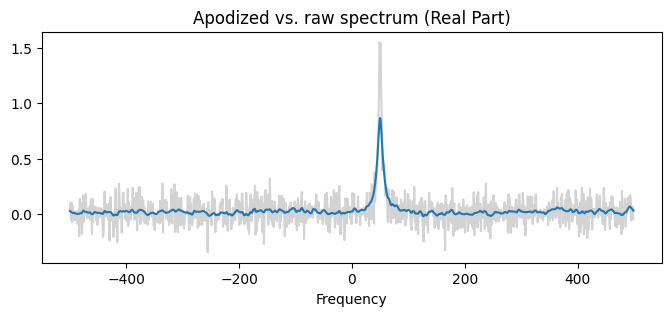

In [10]:
fig, ax = plt.subplots(figsize=(8,3))

da_fid.xmr.to_spectrum().real.plot(ax=ax, color='lightgray')
da_exp.xmr.to_spectrum().real.plot(ax=ax)
plt.title("Apodized vs. raw spectrum (Real Part)")
plt.show()

In [6]:
# STRICT TESTS: Exponential Apodization
_lb = 5.0
_t = da_fid.coords["Time"].values
_expected_weight = np.exp(-np.pi * _lb * _t)
_expected_vals = da_fid.values * _expected_weight

# Prove math
np.testing.assert_allclose(
    da_exp.values, _expected_vals, err_msg="Exponential math failed."
)
# Prove metadata preservation
assert da_exp.dims == da_fid.dims, "Dimensions altered."
np.testing.assert_array_equal(
    da_exp.coords["Time"].values,
    da_fid.coords["Time"].values,
    err_msg="Coords altered.",
)
assert da_exp.attrs == da_fid.attrs, "Attributes dropped."

## 3. Lorentzian-to-Gaussian Transformation

The Lorentzian-to-Gaussian filter converts a standard Lorentzian line shape into a Gaussian line shape, which decays to the baseline in a narrower frequency range. A standard Lorentzian shape produces longer "tails", which is a disadvantage when trying to accurately integrate overlapping resonance lines.

The time-domain FID is multiplied by the function $f_{filter}(t) = e^{+t/T_L}e^{-t^2/T_G^2}$.

The principle is to cancel the Lorentzian part of the FID (using a positive exponential parameterized by $T_L$) while concurrently increasing the Gaussian character of the FID (using the squared exponential parameterized by $T_G$). In `xmris`, we parameterize these using Lorentzian line broadening to cancel (`lb`) and Gaussian line broadening to apply (`gb`).

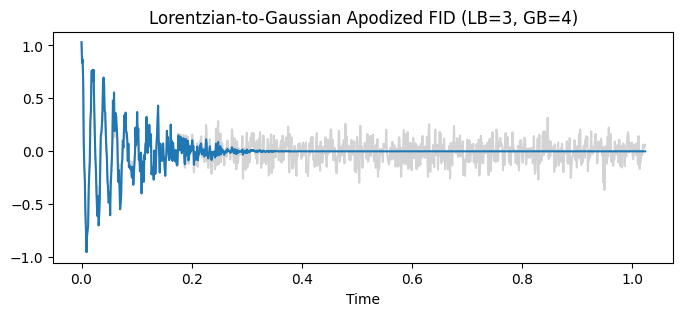

In [7]:
# Cancel 3 Hz of Lorentzian broadening and apply 4 Hz of Gaussian broadening
da_lg = da_fid.xmr.apodize_lg(dim="Time", lb=3.0, gb=4.0)

da_fid.real.plot(figsize=(8, 3), color='lightgray')
da_lg.real.plot()

plt.title("Lorentzian-to-Gaussian Apodized FID (LB=3, GB=4)")
plt.show()

Resulting in the following spectrum:

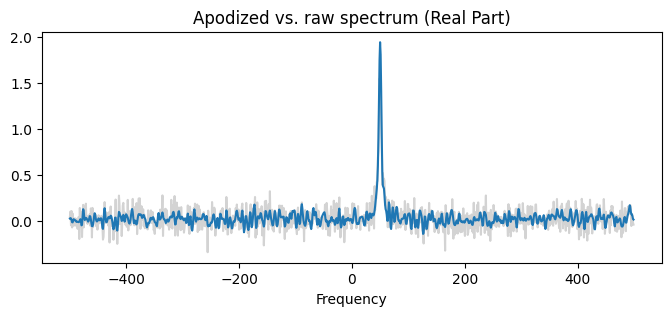

In [8]:
da_fid.xmr.to_spectrum().real.plot(figsize=(8,3), color='lightgray')
da_lg.xmr.to_spectrum().real.plot()
plt.title("Apodized vs. raw spectrum (Real Part)")
plt.show()

In [9]:
# STRICT TESTS: Lorentzian-to-Gaussian Apodization
_lb_lg = 3.0
_gb_lg = 4.0

_weight_lorentzian = np.exp(np.pi * _lb_lg * _t)
_t_g = (2 * np.sqrt(np.log(2))) / (np.pi * _gb_lg)
_weight_gaussian = np.exp(-(_t**2) / (_t_g**2))

_expected_lg_vals = da_fid.values * (_weight_lorentzian * _weight_gaussian)

# Prove math
np.testing.assert_allclose(
    da_lg.values, _expected_lg_vals, err_msg="L-to-G math failed."
)
# Prove metadata preservation
assert da_lg.dims == da_fid.dims, "Dimensions altered."
np.testing.assert_array_equal(
    da_lg.coords["Time"].values, da_fid.coords["Time"].values, err_msg="Coords altered."
)
assert da_lg.attrs == da_fid.attrs, "Attributes dropped."